# get the most likely path (MLP)

In [7]:
# contruct a trace of labels from the answer
# we also have a transition possibility state

# navigate through the graph
# go for the label. if two nodes with same label? select the one with the highest probability
# finish when the path contradicts the answer
import pickle

filename = 'cat'

In [9]:
# open the journey data
with open(f'../data/{filename}_journeys.pkl', 'rb') as f:
    journeys = pickle.load(f)

In [10]:
# create a transition dictionary
transition_dict = {}

for journey in journeys:
    for i in range(len(journey)-1):
        if journey[i] not in transition_dict:
            transition_dict[journey[i]] = {}
        transition_dict[journey[i]][journey[i+1]] = transition_dict[journey[i]].get(journey[i+1], 0) + 1

In [11]:
# create a trace of labels
traces = []

for journey in journeys:
    traces.append(list(map(lambda x: x.split('__')[0], journey)))

In [13]:
# load a graph with pickle
with open(f'../../Dominators/graphs/{filename}_combined_graph.pkl', 'rb') as f:
    G = pickle.load(f)

In [20]:
end = set()
start = set()

for i in range(len(journeys)):
    start.add(journeys[i][0])
    end.add(journeys[i][-1])

if len(start) == 1 and len(end) == 1:
    print('all journeys start and end with the same node')
    start = start.pop()
    end = end.pop()
else:
    raise Exception('journeys do not start and end with the same node')

all journeys start and end with the same node


In [42]:
list(G[start])

['0xdf2060___1', '0x106df90___1']

In [50]:
# get the adjacent nodes
# map transform
list(map(lambda x: x.split('__')[0], list(G[start])))

['0xdf2060', '0x106df90']

In [12]:
import numpy as np
from tqdm import tqdm

done = False

# do bfs with backtracking
def dfs(curr_length, past_nodes):
    global iter_count
    global G
    global done

    # if the current node is the end node with the correct length, finish
    if done or (curr_length == len(traces[iter_count]) and past_nodes[-1] == end):
        done = True
        return past_nodes
    
    # get the next node
    next_label = traces[iter_count][curr_length]
    candidate_nodes = []
    for node in G[curr_node]:
        if node.split('__')[0] == next_label:
            candidate_nodes.append(node)
        
    candidate_nodes.sort(key=lambda x: transition_dict[curr_node][x], reverse=True)

    for node in candidate_nodes:
        dfs(curr_length+1, node, past_nodes + [node])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\mnihy\anaconda3\envs\practicum\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\mnihy\AppData\Local\Temp\ipykernel_22028\688587471.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\mnihy\anaconda3\envs\practicum\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mnihy\anaconda3\envs\practicum\Lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mnihy\anaconda3\envs\practicum\Lib\site-packages\IPython\core\ultratb.py", line 1199, in structured_trace

In [64]:
stats.mean()

0.8335454334787791

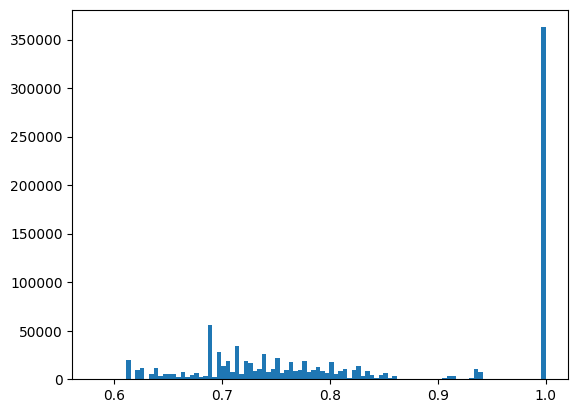

In [65]:
#stats to histogram

import matplotlib.pyplot as plt

plt.hist(stats, bins=100)
plt.show()